# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем библиотеки, с которыми будем работать

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

import re 
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords') 
from nltk.corpus import stopwords 

from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Сохраним данные в переменную `df` и посмотрим первые 10 строк датасета:

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Посмотрим общую информацию о данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


159 571 комментарий в нашем датасете, пропущенных значений нет.
Проверим датасет на наличие дубликатов.

In [5]:
df.duplicated().sum()

0

Дубликатов в таблице нет.
Напишем функцию очистки и лемматизации текста.

In [6]:
def clear_text(text):
    text = text.lower()
    text = " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())
    return text

lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_text

In [7]:
df['lemmatized_text'] = df['text'].apply(clear_text)
df['lemmatized_text'] = df['lemmatized_text'].apply(lemmatize)
df

,text,toxic,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


Удалим столбец с исходным текстом.

In [8]:
df = df.drop(['text'], axis=1)
df

,toxic,lemmatized_text
0,0,explanation why the edits made under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not trying to edit war it s...
3,0,more i can t make any real suggestion on impro...
4,0,you sir are my hero any chance you remember wh...
...,...,...
159566,0,and for the second time of asking when your vi...
159567,0,you should be ashamed of yourself that is a ho...
159568,0,spitzer umm there no actual article for prosti...
159569,0,and it look like it wa actually you who put on...


Проверим насколько сбалансированны данные.

0    0.898321
1    0.101679
Name: toxic, dtype: float64


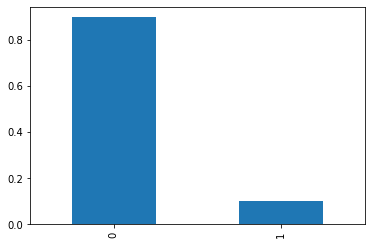

In [9]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

In [10]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Мы наблюдаем дисбаланс классов - негативные комментарии пишут в 10% случаев (отрицательный класс меньше положительного в 9 раз). При обучении моделей укажем параметр class_weight = None.

Нам нужно построить модель для задачи классификации. Для этого разделим исходные данные на выборки - обучающую и тестовую в соотношении 80:20.

In [11]:
features = df['lemmatized_text']
target = df['toxic']

In [12]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=12345,
                                                                            stratify=target)

Преобразуем тексты в векторы:

In [13]:
# загружаем stop слова
stop_words = set(stopwords.words('english'))
# создаем tf-idf
count_tf_idf = TfidfVectorizer(stop_words = stop_words)
# обучаем и преобразуем обучающую выборку
features_train = count_tf_idf.fit_transform(features_train.values.astype('U'))
# преобразуем тестовую выборку
features_test = count_tf_idf.transform(features_test.values.astype('U'))

### Вывод

Мы предобработали данные - лемматизировали тексты, очистили от спецсимволов, удалили столбец с исходным текстом. Разделили данные на выборки, преобразовали тексты в векторы. Данные готовы к дальнейшей работе.

## Обучение

### Логистическая регрессия

In [14]:
%%time
# инициализируем модель
logreg = LogisticRegression(random_state = 12345, class_weight = None)

# задаем параметры для модуля GridSearch
param_grid = {'C': [10,100], 'solver':['liblinear', 'saga'], 'max_iter':[100,200]}

# ищем лучшие параметры 
grid_logreg = GridSearchCV(logreg, param_grid, cv = 5, n_jobs = -1, scoring = 'f1')

# обучаем модель на тренировочных данных
grid_logreg.fit(features_train, target_train)

print('Лучшие параметры модели логистической регрессии:', grid_logreg.best_params_)
print('Лучшая метрика F1 модели логистической регрессии:', grid_logreg.best_score_)
print()

Лучшие параметры модели логистической регрессии: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Лучшая метрика F1 модели логистической регрессии: 0.762260673995937

CPU times: total: 2.23 s
Wall time: 1min 49s


### Решающее дерево

In [15]:
%%time

# инициализируем модель
dt = DecisionTreeClassifier(random_state=12345, class_weight = None)

# задаем параметры для модуля GridSearch 
param_grid = {
 'max_depth': [1, 10, 20],
 'min_samples_split': [8, 10, 12, 14, 16]
 }

# ищем лучшие параметры 
grid_dt = GridSearchCV(estimator = dt, param_grid = param_grid, cv= 5, n_jobs = -1, scoring = 'f1') 

# обучаем модель на тренировочных данных
grid_dt.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели решающего дерева:', grid_dt.best_params_)
print()

# получаем лучшую оценку 
print('Лучшая метрика F1 модели решающего дерева:', grid_dt.best_score_)
print()

Лучшие параметры модели решающего дерева: {'max_depth': 20, 'min_samples_split': 8}

Лучшая метрика F1 модели решающего дерева: 0.6520058904902141

CPU times: total: 10.2 s
Wall time: 3min 51s


### Случайный лес

In [16]:
%%time

# инициализируем модель
rf = RandomForestClassifier(random_state=12345, class_weight = None)

# задаем параметры для модуля GridSearch 
param_grid = {
 'max_depth': [1, 10, 20],
 'n_estimators': [100, 200]
}

# ищем лучшие параметры 
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv= 5, n_jobs = -1, scoring='f1') 

# обучаем модель на тренировочных данных
grid_rf.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели случайного леса:', grid_rf.best_params_)
print()

# получаем лучшую оценку 
print('Лучшая метрика F1 модели случайного леса:', grid_rf.best_score_)
print()

Лучшие параметры модели случайного леса: {'max_depth': 20, 'n_estimators': 100}

Лучшая метрика F1 модели случайного леса: 0.0009237876657338217

CPU times: total: 6.64 s
Wall time: 4min 30s


### LightGBM

In [17]:
%%time
# инициализируем модель
model = LGBMClassifier(random_state=12345, class_weight = None)

# задаем параметры для модуля GridSearch ф
param_grid = {'max_depth': range(10, 21, 5),
              'n_estimators': range(10, 51, 10)}
  
# ищем лучшие параметры 
grid_model = GridSearchCV(estimator = model, param_grid = param_grid, cv= 5, n_jobs = -1, scoring= 'f1', verbose = 10) 

# обучаем модель на тренировочных данных
grid_model.fit(features_train, target_train)

# получаем лучшие параметры модели
print('Лучшие параметры модели LGBMC:', grid_model.best_params_)
print()

# получаем лучшую оценку
print('Лучшая метрика F1 модели LGBMC:', grid_model.best_score_)
print()

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучшие параметры модели LGBMC: {'max_depth': 20, 'n_estimators': 50}

Лучшая метрика F1 модели LGBMC: 0.6899758463659129

CPU times: total: 1min 17s
Wall time: 7min 7s


Лучшее значение метрики F1 на обучающей выборке, соответствующее условиям задачи, получилось у модели логистической  
регрессии - 0,76 с параметрами: 'C': 10, 'max_iter': 100, 'solver': 'liblinear'. Проверим работу моделей на тестовой выборке.

## Тестирование

#### Логистическая регрессия

Лучшие параметры модели логистической регрессии: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}

In [18]:
%%time

# инициализируем модель
logreg = LogisticRegression(random_state=12345, class_weight = None, C=10, max_iter=100, solver='liblinear')

# обучаем модель на тренировочной выборке
logreg.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_logreg = logreg.predict(features_test)

# оцениваем модель
f1_logreg = f1_score(target_test, predictions_logreg)
print('Мера F1 модели линейной регрессии:', f1_logreg)
print()

Мера F1 модели линейной регрессии: 0.7776243093922652

CPU times: total: 1.73 s
Wall time: 1.5 s


#### Решающее дерево

Лучшие параметры модели решающего дерева: {'max_depth': 20, 'min_samples_split': 8}

In [19]:
%%time

# инициализируем модель
dt = DecisionTreeClassifier(random_state=12345, class_weight = None, max_depth = 20, min_samples_split = 8)

# обучаем модель на тренировочной выборке
dt.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_dt = dt.predict(features_test)

# оцениваем модель
f1_dt = f1_score(target_test, predictions_dt)
print('Мера F1 модели решающего дерева:', f1_dt)
print()

Мера F1 модели решающего дерева: 0.6442477876106195

CPU times: total: 9.44 s
Wall time: 9.49 s


#### Случайный лес

Лучшие параметры модели случайного леса: {'max_depth': 20, 'n_estimators': 100}

In [20]:
%%time

# инициализируем модель
rf = RandomForestClassifier(random_state=12345, class_weight = None, max_depth = 20, n_estimators = 100)

# обучаем модель на тренировочной выборке
rf.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_rf = rf.predict(features_test)

# оцениваем модель
f1_rf = f1_score(target_test, predictions_rf)
print('Мера F1 модели случайного леса:', f1_rf)
print()

Мера F1 модели случайного леса: 0.0012319063751154912

CPU times: total: 6.78 s
Wall time: 6.76 s


#### LightGBM

Лучшие параметры модели LGBMC: {'max_depth': 20, 'n_estimators': 50}

In [21]:
%%time

# инициализируем модель
model_LGBMC = LGBMClassifier(random_state=12345, class_weight = None, max_depth = 20, n_estimators = 50)

# обучаем модель на тренировочной выборке
model_LGBMC.fit(features_train, target_train)

# находим предсказания на тестовой выборке
predictions_LGBMC = model_LGBMC.predict(features_test)

# оцениваем модель
f1_LGBMC = f1_score(target_test, predictions_LGBMC)
print('Мера F1 для модели LGBMR:', f1_LGBMC)
print()

Мера F1 для модели LGBMR: 0.6736015701668302

CPU times: total: 1min 15s
Wall time: 14.4 s


Лучшее значение метрики F1 на тестовой выборке получили для модели логистической регрессии - 0,7776. Худшее значение F1 у модели случайного леса.

## Выводы

Объект нашего исследования - данные с разметкой о токсичности правок к описаниям товаров интернет-магазина "Викишоп".

В ходе предобработки мы подготовили данные к моделированию:
* лемматизировали тексты, 
* очистили от спецсимволов,
* удалили столбец с исходным текстом, 
* преобразовали тексты в векторы. 

Для решения поставленной задачи мы разделили данные на две выборки:
1. обучающую,
2. тестовую.

Обучили и проверили модели логистической регрессии, решающего дерева, случайного леса и модель градиентного бустинга LightGBMClassifier.

По результатам обучения мы проверили все модели на тестовых выборках. Самое лучшее заначение метрики F1 0,7776 получили для модели логистической регресси на тестовой выборке.

Подведём итог нашей работы - рекомендация для интернет-магазина "Викишоп":
- чтобы искать токсичные комментарии и отправлять их на модерацию, рекомендуем использовать модель логистической регрессии с характеристиками:
    * C=10, 
    * max_iter=100, 
    * solver='liblinear'.